In [1]:
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/Karimian_Faezeh/.cdsapirc")

# Assessment of bias, RMS deviation (RMSD), and correlation between the two datasets at regional scales for the years 2018–2019


&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche ([CNR](https://www.cnr.it/en)- Fabio Madonna and Faezeh Karimian.)

## 🌍 Use case: Regional consistency of surface albedo datasets
## ❓ Quality assessment questions

**• How consistent are Sentinel-3 and PROBA-V albedo estimates in specific regions such as the Alps, Pyrenees, Sahara Desert, or Mediterranean?**

The Mediterranean basin and North Africa represent key regions for albedo monitoring due to their climatic and land surface diversity. The Mediterranean combines densely populated coastal zones with heterogeneous landscapes (forests, croplands and mountains), while North Africa is dominated by the Sahara Desert, one of the largest and brightest natural surfaces on Earth. The presence of snow cover in mountain ranges (e.g., the Alps, Pyrenees, and Atlas Mountains), strong vegetation seasonality, and the influence of dust and aerosols further complicate albedo retrievals from space in this domain (Carrer et al., 2018; Liang et al., 2020).
Two satellite missions from the European Space Agency provide long-term surface albedo products suitable for such analyses: Sentinel-3 (OLCI + SLSTR), delivering albedo at 300 m resolution, and PROBA-V (VGT sensor), delivering albedo at 1 km resolution. Both datasets are accessible through the Copernicus Climate Data Store (CDS) and form part of the Essential Climate Variables (ECVs) for land monitoring (Copernicus, 2020; Dierckx et al., 2014).

Previous studies have assessed albedo products at global scales, but regional evaluations over the Mediterranean and North Africa remain limited. These areas are of high climatic relevance due to strong land–atmosphere coupling, rapid land cover changes, and their role in the energy balance of the Euro-Mediterranean climate system (Giorgi, 2006; Cherif et al., 2020).

This study compares Sentinel-3 and PROBA-V surface albedo products over the Mediterranean and North Africa for the period 2018–2019. By analyzing regional time series and computing bias, RMS deviation (RMSD), and correlation, the study aims to quantify the agreement between the two datasets at the regional scale.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note

• Across most regions, Sentinel-3 and PROBA-V albedo datasets show very high correlations (>0.9) for black-sky and white-sky visible albedo (AL_BH_VI, AL_DH_VI). This indicates strong consistency in the visible band.  

• Negative biases (Sentinel-3 lower than PROBA-V) dominate in mountain regions (Alps, Pyrenees, Apennines, Black Forest), with values typically between –0.01 and –0.02. These biases are most pronounced in the diffuse broadband albedo (for example, the AL_DH_BB bias ≈ –0.026 in the Alps and Po Valley).  

• Over the Central Mediterranean Sea region, biases are small and slightly positive (~+0.004–0.007), and correlations are high in the visible albedo (>0.97). This suggests that Sentinel-3 tends to retrieve slightly higher albedo values over water surfaces, while diffuse broadband albedo shows weaker correlation (r ≈ 0.65), indicating greater uncertainty in marine environments.  

• The Sahara Desert exhibits excellent agreement with low RMSD (<0.02) and high correlation (>0.9 for most variables). The only exception is a stronger negative bias in visible albedo (AL_BH_VI ≈ –0.036), possibly related to surface brightness and sensor calibration differences.  

• The Black Forest region shows a strong breakdown in correlation for diffuse broadband albedo (AL_DH_BB, r ≈ 0.00), highlighting challenges in dense forest environments where retrieval algorithms differ more strongly.  

• Seasonal cycles are captured consistently in all regions, but diffuse albedo metrics (AL_DH_BB) tend to have weaker correlations (0.65–0.78 in Central Med., Po Valley, Apennines), pointing to sensitivity to cloudiness, atmospheric conditions, or retrieval assumptions.  

• Overall, the two datasets are fit for regional albedo monitoring across the Mediterranean and North Africa, but caution is required in snow-affected mountains, dense forest areas, and marine regions where retrievals are less reliable.  


## 📋 Methodology

This assessment aims to evaluate the bias, RMS deviation (RMSD), and correlation between surface albedo products from PROBA-V and Sentinel-3 (OLCI/SLSTR). The comparison is performed at a regional scale over the period 2018–2019.

The methodology adopted for the analysis is split into the following steps:

[](section-1) 
* Import all required libraries  
* Spatial and temporal definitions  

[](section-2)  
* Download the albedo data
* Data preparation
* Define required functions
* Normalizing coordinates
* Regrid Sentinel-3 to PROBA-V grid
* Computation of timeseries   

[](section-3)  
* Metrics per variable
* Build a tidy monthly diff table for each variable
* Regional Case Studies
* Plot monthly time series (S3 vs PV) for each region & variable
* Plot full-domain monthly time-series plots


[](section-4) 


## 📈 Analysis and results

(section-1)=
### Choose the data to use and set up the code

#### Import all required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [ ]:
import calendar
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from c3s_eqc_automatic_quality_control import download

#### Spatial and temporal definitions

The analysis in this assessment focuses on data from July 2018 to April 2019, using monthly averages derived from Sentinel-3 (OLCI+SLSTR) and PROBA-V (VGT). The study domain covers selected regions across the Mediterranean Basin and North Africa, including the Alps, Pyrenees, Po Valley, Apennines, Black Forest, Central Mediterranean Sea, and the Sahara Desert. Each subregion is defined by specific latitude and longitude bounds and used to compute area-weighted regional means.

In [ ]:
start = "2018-07"
stop = "2019-04"
area = [50.1, -12.1, 15.7, 30.0]
variables = ["albb_bh", "albb_dh", "alsp_bh", "alsp_dh"]


#4. Regional Case Studies 

regions = {
    "Alps":                (5.0, 15.0, 44.0, 48.0),
    "Central_Med_Sea":     (14.0, 20.0, 33.0, 36.0),   
    "Pyrenees":            (-1.5, 3.0, 42.0, 43.8),
    "Po_Valley":           (7.0, 12.0, 44.0, 46.8),
    "Apennines":           (11.0, 15.0, 41.0, 44.5),
    "Black_Forest":        (7.0, 9.5, 47.0, 49.5),
    "Sahara_Desert":       (-10.0, 5.0, 20.0, 28.0),
}

(section-2)=
### Data Retrieval and Preparation
In this step, the selected satellite data is downloaded using predefined time and variable settings. The data is then formatted to include a clear time coordinate, and average maps of key variables like AOD550 and FM_AOD550 are calculated over the full time period to prepare for analysis and visualization.

#### Download the albedo data

In [ ]:
collection_id = "satellite-albedo"
satellite_requests = {
    "proba": {
        "sensor": "vgt",
        "product_version": ["v2"],
        "horizontal_resolution": ["1km"],
    },
    "sentinel_3": {
        "sensor": "olci_and_slstr",
        "product_version": ["v3"],
        "horizontal_resolution": ["300m"],
    },
}

# Download and transform
datasets = {}
for satellite, request in satellite_requests.items():
    print(f"{satellite=}")
    requests = []
    for date in pd.date_range(start, stop, freq="1MS"):
        _, last_day = calendar.monthrange(date.year, date.month)
        requests.append(
            request
            | {
                "satellite": satellite,
                "variable": variables,
                "year": str(date.year),
                "month": f"{date.month:02d}",
                "nominal_day": ["10", "20", str(last_day)],
                "area": list(map(float, area)),
            }
        )
    datasets[satellite] = download.download_and_transform(
        collection_id,
        requests,
        data_vars="minimal",
        coords="minimal",
        compat="override",
    )

satellite='proba'



100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


satellite='sentinel_3'



100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


#### Data preparation


In [ ]:

ds_pv = datasets["proba"]        # Proba-V (1km) -> target grid
ds_s3 = datasets["sentinel_3"]   # Sentinel-3 (300m) -> will regrid to PV

want = ["AL_BH_BB", "AL_DH_BB", "AL_BH_VI", "AL_DH_VI"]
vars_use = [v for v in want if (v in ds_pv.data_vars and v in ds_s3.data_vars)]
if not vars_use:
    raise KeyError("None of the expected variables found in both datasets.")
ds_pv = ds_pv[vars_use]
ds_s3 = ds_s3[vars_use]

#### Define requiered functions

In [ ]:
def ensure_strictly_increasing(ds, coord):
    """Sort by coord and drop any duplicates so interpolation works."""
    ds = ds.sortby(coord)
    vals = ds[coord].values
    # round to avoid fp noise, then dedupe
    vals_r = np.round(vals.astype("float64"), 6)
    uniq, keep_idx = np.unique(vals_r, return_index=True)
    if keep_idx.size != vals.size:
        ds = ds.isel({coord: np.sort(keep_idx)}).assign_coords({coord: vals_r[np.sort(keep_idx)]})
    else:
        ds = ds.assign_coords({coord: vals_r})
    return ds



def normalize_lon(ds):
    lon = ds["longitude"].values
    if lon.min() >= 0 and lon.max() > 180:
        lon = ((lon + 180) % 360) - 180
        ds = ds.assign_coords(longitude=lon).sortby("longitude")
    return ds

def global_mean_weighted(da: xr.DataArray) -> xr.DataArray:
    """
    Area-weighted spatial mean per time step (lat-weighted, NaN-safe).
    Works without .weighted() and with dask.
    """
    # Broadcast lat-weights across lon/time by arithmetic broadcasting
    num = (da * w_lat).sum(dim=("latitude", "longitude"), skipna=True)
    den = (xr.where(np.isfinite(da), 1.0, 0.0) * w_lat).sum(dim=("latitude", "longitude"))
    return num / den

def monthly_series(da: xr.DataArray) -> pd.Series:
    """
    Global mean per time -> monthly mean series as pandas Series.
    Uses groupby on time Periods (robust to irregular 10/20/last-day dates).
    """
    gm = global_mean_weighted(da)                      # 1D over time
    s = gm.to_series()                                 # compute if dask
    m = s.groupby(s.index.to_period("M")).mean()       # monthly means
    return m.to_timestamp(how="start")                 # index at month start


####  Normalizing coordinates

In [ ]:
ds_pv = normalize_lon(ds_pv)
ds_s3 = normalize_lon(ds_s3)
 
ds_pv = ensure_strictly_increasing(ds_pv, "latitude").sortby("longitude")
ds_s3 = ensure_strictly_increasing(ds_s3, "latitude").sortby("longitude")
ds_pv = normalize_lon(ds_pv)
ds_s3 = normalize_lon(ds_s3)


#### Regrid Sentinel-3 to PROBA-V grid

In [ ]:

ds_s3_rg = ds_s3.interp(latitude=ds_pv.latitude, longitude=ds_pv.longitude)

#  Mask invalid albedo (keep [0,1])
ds_pv    = ds_pv.where((ds_pv >= 0) & (ds_pv <= 1))
ds_s3_rg = ds_s3_rg.where((ds_s3_rg >= 0) & (ds_s3_rg <= 1))

pv_time = np.asarray(ds_pv.time.values, dtype="datetime64[ns]")
s3_time = np.asarray(ds_s3_rg.time.values, dtype="datetime64[ns]")
common_time = np.intersect1d(pv_time, s3_time)
if common_time.size == 0:
    raise ValueError("No overlapping times after normalization.")
ds_pv    = ds_pv.sel(time=common_time)
ds_s3_rg = ds_s3_rg.sel(time=common_time)


tmin = pd.to_datetime(ds_pv.time.min().values)
tmax = pd.to_datetime(ds_pv.time.max().values)
for ds in (ds_pv, ds_s3_rg):
    ds.attrs.update({
        "time_coverage_start": tmin.strftime("%Y-%m-%dT%H:%M:%SZ"),
        "time_coverage_end":   tmax.strftime("%Y-%m-%dT%H:%M:%SZ"),
    })
ds_pv    = ds_pv.chunk({"time": 1, "latitude": 512, "longitude": 512})
ds_s3_rg = ds_s3_rg.chunk({"time": 1, "latitude": 512, "longitude": 512})


assert np.array_equal(ds_pv.time.values, ds_s3_rg.time.values)
assert np.array_equal(ds_pv.latitude.values, ds_s3_rg.latitude.values)
assert np.array_equal(ds_pv.longitude.values, ds_s3_rg.longitude.values)



vars_use = list(ds_pv.data_vars)


w_lat = np.cos(np.deg2rad(ds_pv.latitude))
w_lat = w_lat / w_lat.mean()

#### Computation of timeseries

In [ ]:
#  Build monthly time series per variable for S3 and PV
s3_monthly = {v: monthly_series(ds_s3_rg[v]) for v in vars_use}
pv_monthly = {v: monthly_series(ds_pv[v])    for v in vars_use}

print(s3_monthly)
print(pv_monthly)

{'AL_BH_BB': time
2018-07-01    0.337296
2018-08-01    0.332349
2018-09-01    0.330755
2018-10-01    0.324169
2018-11-01    0.317215
2018-12-01    0.314358
2019-01-01    0.317790
2019-02-01    0.322398
2019-03-01    0.325821
2019-04-01    0.324855
Freq: MS, dtype: float64, 'AL_DH_BB': time
2018-07-01    0.340296
2018-08-01    0.335331
2018-09-01    0.333684
2018-10-01    0.327390
2018-11-01    0.321421
2018-12-01    0.318299
2019-01-01    0.320556
2019-02-01    0.324229
2019-03-01    0.327485
2019-04-01    0.326562
Freq: MS, dtype: float64, 'AL_BH_VI': time
2018-07-01    0.192046
2018-08-01    0.188274
2018-09-01    0.187777
2018-10-01    0.184372
2018-11-01    0.181179
2018-12-01    0.184031
2019-01-01    0.190742
2019-02-01    0.192383
2019-03-01    0.191124
2019-04-01    0.188440
Freq: MS, dtype: float64, 'AL_DH_VI': time
2018-07-01    0.205592
2018-08-01    0.201033
2018-09-01    0.200127
2018-10-01    0.196880
2018-11-01    0.194131
2018-12-01    0.197460
2019-01-01    0.203935
20

(section-3)=
### 3. Plot and describe the results.

#### Metrics per variable

In [ ]:
# Metrics per variable (months aligned, NaN-safe)
rows = []
for v in sorted(s3_monthly.keys()):
    s = s3_monthly[v]
    p = pv_monthly[v]
    idx = s.index.intersection(p.index)
    df = pd.DataFrame({"s3": s.reindex(idx), "pv": p.reindex(idx)}).dropna()
    if df.empty:
        rows.append({"variable": v, "n_months": 0, "bias": np.nan, "rmsd": np.nan, "corr": np.nan})
        continue
    d = df["s3"] - df["pv"]
    rows.append({
        "variable": v,
        "n_months": len(df),
        "bias": float(d.mean()),
        "rmsd": float(np.sqrt((d**2).mean())),
        "corr": float(df["s3"].corr(df["pv"]))
    })

out = pd.DataFrame(rows).set_index("variable").sort_index()
print(out.to_string(float_format=lambda x: f"{x:.6f}"))

          n_months      bias     rmsd     corr
variable                                      
AL_BH_BB        10 -0.013679 0.013923 0.968835
AL_BH_VI        10 -0.027536 0.027591 0.920367
AL_DH_BB        10  0.000286 0.005474 0.572778
AL_DH_VI        10 -0.007717 0.008551 0.571905


#### Build a tidy monthly diff table for each variable

In [ ]:
# build a tidy monthly diff table for each variable
monthly_tables = {}
for v in sorted(s3_monthly.keys()):
    idx = s3_monthly[v].index.intersection(pv_monthly[v].index)
    monthly_tables[v] = pd.DataFrame({
        "S3": s3_monthly[v].reindex(idx),
        "PV": pv_monthly[v].reindex(idx),
        "S3-PV": (s3_monthly[v] - pv_monthly[v]).reindex(idx)
    }).dropna()
    # peek
    print(f"\n{v} monthly means:")
    print(monthly_tables[v].round(6))


AL_BH_BB monthly means:
                  S3        PV     S3-PV
time                                    
2018-07-01  0.337296  0.357331 -0.020036
2018-08-01  0.332349  0.347574 -0.015224
2018-09-01  0.330755  0.342306 -0.011551
2018-10-01  0.324169  0.338786 -0.014617
2018-11-01  0.317215  0.328633 -0.011418
2018-12-01  0.314358  0.326856 -0.012497
2019-01-01  0.317790  0.332799 -0.015010
2019-02-01  0.322398  0.333602 -0.011204
2019-03-01  0.325821  0.337294 -0.011474
2019-04-01  0.324855  0.338610 -0.013755

AL_BH_VI monthly means:
                  S3        PV     S3-PV
time                                    
2018-07-01  0.192046  0.222828 -0.030782
2018-08-01  0.188274  0.216823 -0.028549
2018-09-01  0.187777  0.213795 -0.026018
2018-10-01  0.184372  0.213045 -0.028673
2018-11-01  0.181179  0.208273 -0.027094
2018-12-01  0.184031  0.210073 -0.026041
2019-01-01  0.190742  0.220751 -0.030010
2019-02-01  0.192383  0.218667 -0.026284
2019-03-01  0.191124  0.217125 -0.026001
2019-04

#### Regional Case Studies

In [ ]:
regions = {
    "Alps":                (5.0, 15.0, 44.0, 48.0),
    "Central_Med_Sea":     (14.0, 20.0, 33.0, 36.0),   
    "Pyrenees":            (-1.5, 3.0, 42.0, 43.8),
    "Po_Valley":           (7.0, 12.0, 44.0, 46.8),
    "Apennines":           (11.0, 15.0, 41.0, 44.5),
    "Black_Forest":        (7.0, 9.5, 47.0, 49.5),
    "Sahara_Desert":       (-10.0, 5.0, 20.0, 28.0),
}

# Variables to evaluate (present in both datasets)
vars_use = [v for v in ["AL_BH_BB","AL_DH_BB","AL_BH_VI","AL_DH_VI"]
            if v in ds_pv.data_vars and v in ds_s3_rg.data_vars]

def _subset_region(ds: xr.Dataset, bounds):
    """Clip to the intersection of 'bounds' and the dataset's extent."""
    lon_min, lon_max, lat_min, lat_max = bounds
    lon0, lon1 = float(ds.longitude.min()), float(ds.longitude.max())
    lat0, lat1 = float(ds.latitude.min()),  float(ds.latitude.max())
    a_lon_min, a_lon_max = max(lon_min, lon0), min(lon_max, lon1)
    a_lat_min, a_lat_max = max(lat_min, lat0), min(lat_max, lat1)
    if not (a_lon_min < a_lon_max and a_lat_min < a_lat_max):
        return None  # no overlap
    try:
        return utils.regionalise(ds, lon_slice=(a_lon_min, a_lon_max),
                                    lat_slice=(a_lat_min, a_lat_max))
    except Exception:
        return ds.sel(longitude=slice(a_lon_min, a_lon_max),
                      latitude =slice(a_lat_min, a_lat_max))

def _monthly_series_weighted(da: xr.DataArray) -> pd.Series:
    """Region-weighted spatial mean per time -> monthly mean (Series)."""
    # latitude weights (area ∝ cos φ), normalized over the subset
    w = np.cos(np.deg2rad(da.latitude))
    w = w / w.mean()
    num = (da * w).sum(dim=("latitude","longitude"), skipna=True)
    den = (xr.where(np.isfinite(da), 1.0, 0.0) * w).sum(dim=("latitude","longitude"))
    ts = (num / den).to_series()  # 1D over time (may be all-NaN if no valid pixels)
    m = ts.groupby(ts.index.to_period("M")).mean()
    return m.to_timestamp(how="start")

def compute_region_metrics(ds_s3: xr.Dataset, ds_pv: xr.Dataset, bounds, vars_use):
    """Return DataFrame of bias/RMSD/corr (S3 vs PV) for a region."""
    s3_reg = _subset_region(ds_s3, bounds)
    pv_reg = _subset_region(ds_pv, bounds)
    if s3_reg is None or pv_reg is None:
        return None
    rows = []
    for v in vars_use:
        s3_m = _monthly_series_weighted(s3_reg[v])
        pv_m = _monthly_series_weighted(pv_reg[v])
        idx = s3_m.index.intersection(pv_m.index)
        df = pd.DataFrame({"s3": s3_m.reindex(idx), "pv": pv_m.reindex(idx)}).dropna()
        if df.empty:
            rows.append({"variable": v, "n_months": 0, "bias": np.nan, "rmsd": np.nan, "corr": np.nan})
            continue
        d = df["s3"] - df["pv"]
        rows.append({
            "variable": v,
            "n_months": len(df),
            "bias": float(d.mean()),
            "rmsd": float(np.sqrt((d**2).mean())),
            "corr": float(df["s3"].corr(df["pv"])),
        })
    return pd.DataFrame(rows).set_index("variable").sort_index()

#  Run for all regions
for name, bounds in regions.items():
    metrics = compute_region_metrics(ds_s3_rg, ds_pv, bounds, vars_use)
    if metrics is None:
        print(f"{name}: (skipped — outside dataset coverage)")
    else:
        # If all rows are NaN (e.g., open water only), note it clearly
        if metrics["n_months"].sum() == 0:
            print(f"{name}: no valid pixels for monthly stats (likely water-only for these products).")
        else:
            print(f"\n{name} metrics (S3 vs PV):")
            print(metrics.to_string(float_format=lambda x: f"{x:.6f}"))
 


Alps metrics (S3 vs PV):
          n_months      bias     rmsd     corr
variable                                      
AL_BH_BB        10 -0.019920 0.021729 0.937175
AL_BH_VI        10 -0.013449 0.015783 0.994077
AL_DH_BB        10 -0.025603 0.030618 0.742944
AL_DH_VI        10 -0.016040 0.019107 0.993325

Central_Med_Sea metrics (S3 vs PV):
          n_months     bias     rmsd     corr
variable                                     
AL_BH_BB        10 0.005040 0.005664 0.793091
AL_BH_VI        10 0.004252 0.004871 0.978351
AL_DH_BB        10 0.004371 0.006145 0.649131
AL_DH_VI        10 0.007437 0.007852 0.980778

Pyrenees metrics (S3 vs PV):
          n_months      bias     rmsd     corr
variable                                      
AL_BH_BB        10 -0.009863 0.010026 0.991194
AL_BH_VI        10 -0.005246 0.006332 0.980904
AL_DH_BB        10 -0.010961 0.012947 0.717824
AL_DH_VI        10 -0.004284 0.005934 0.974981

Po_Valley metrics (S3 vs PV):
          n_months      bias     rms

#### Plot monthly time series (S3 vs PV) for each region & variable 

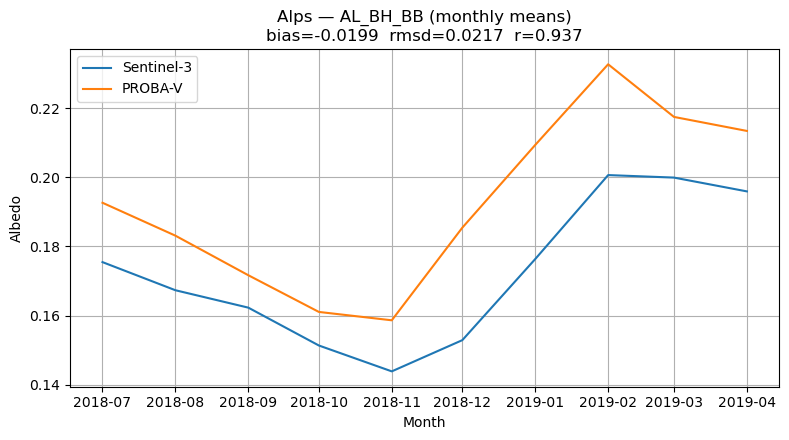

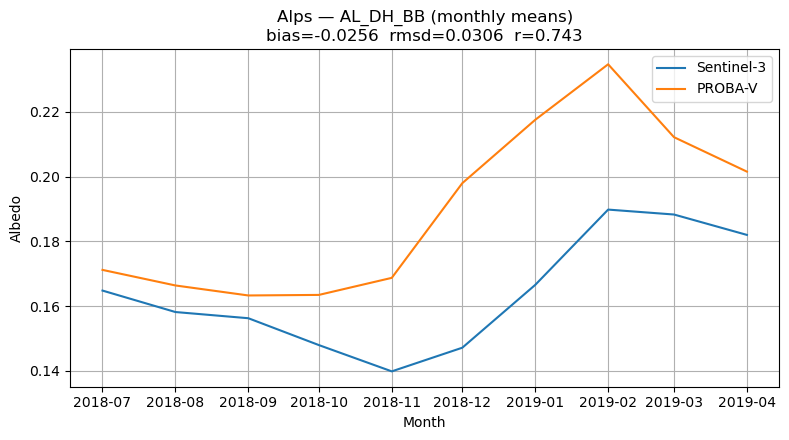

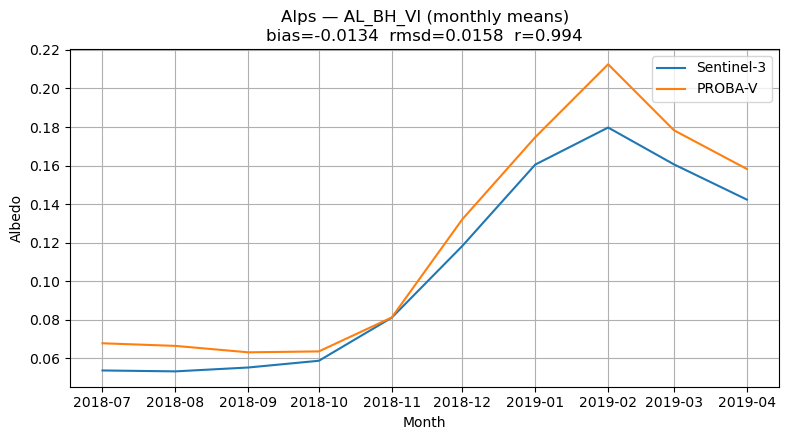

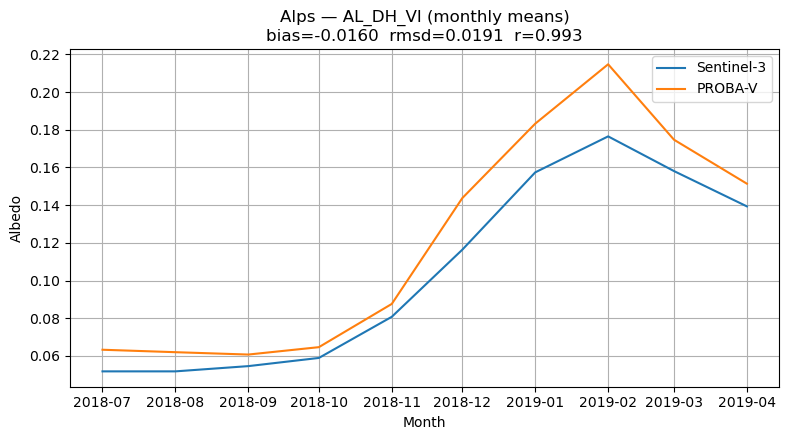

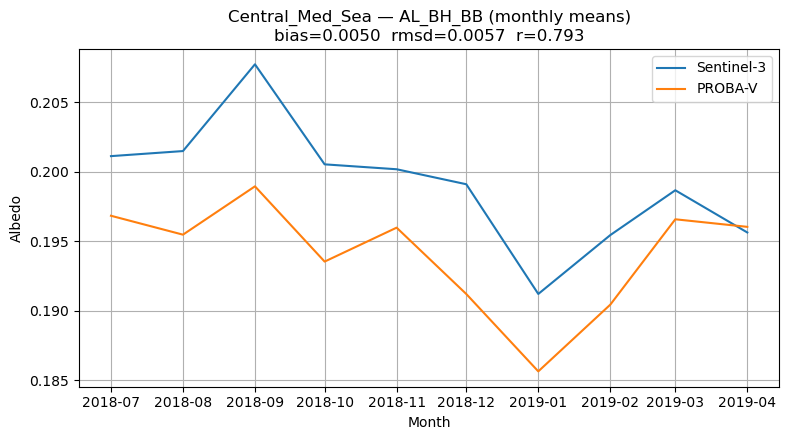

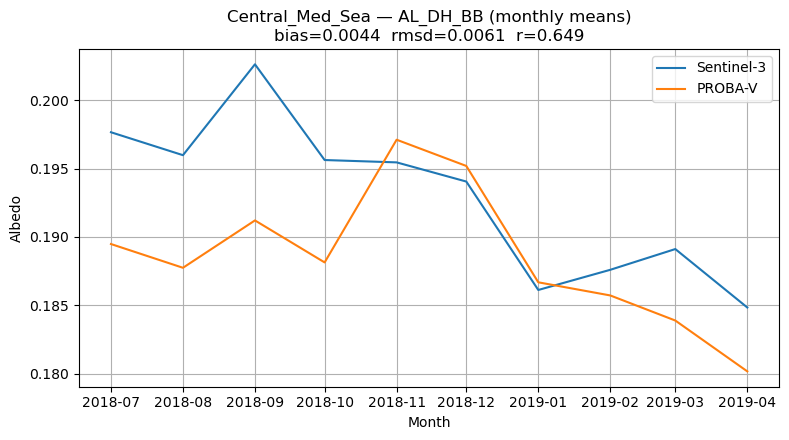

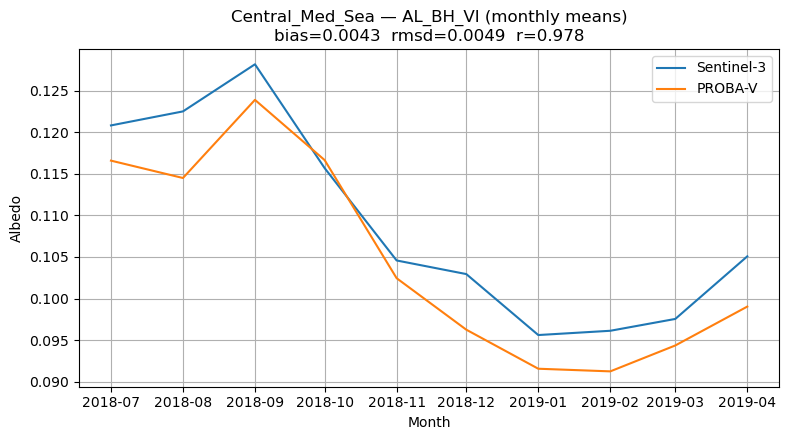

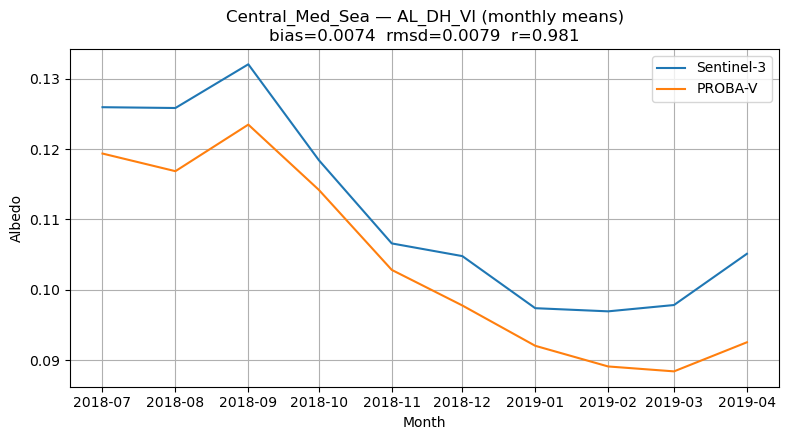

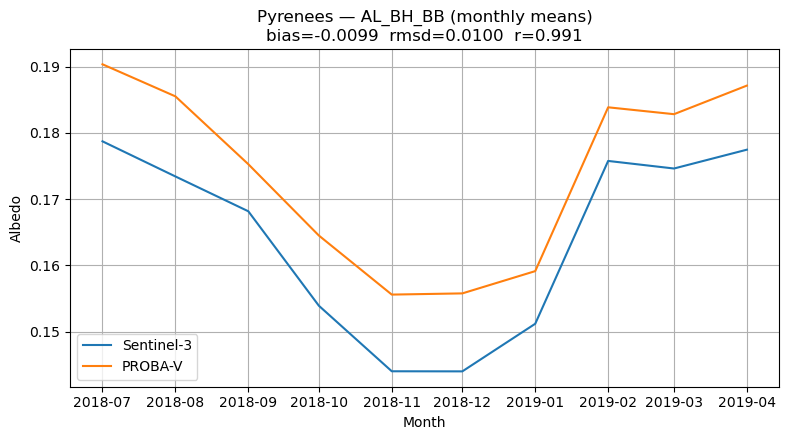

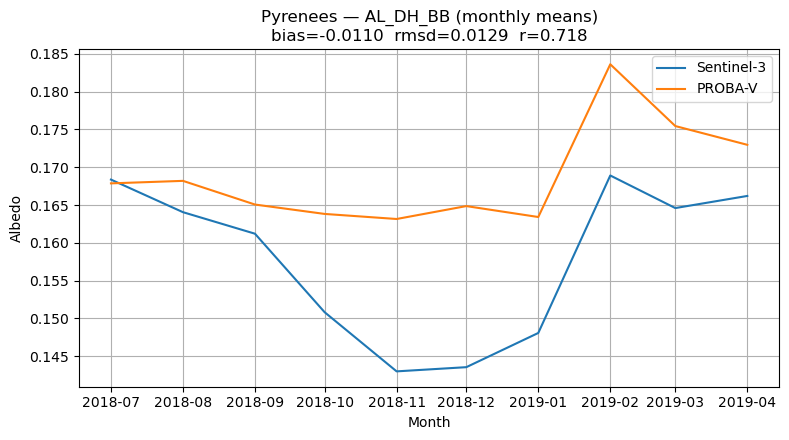

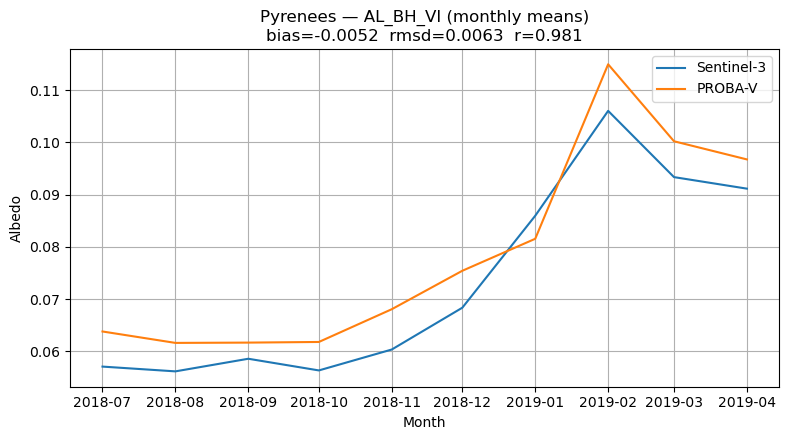

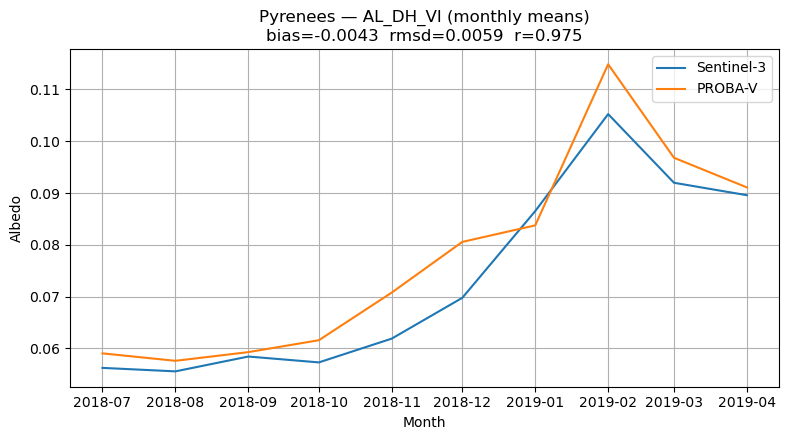

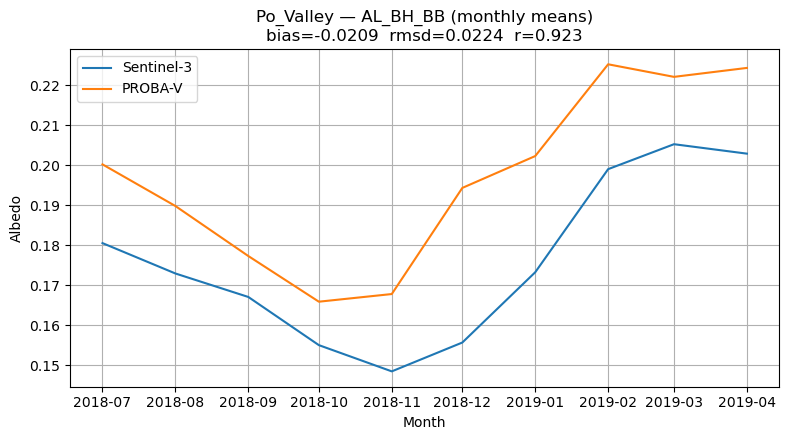

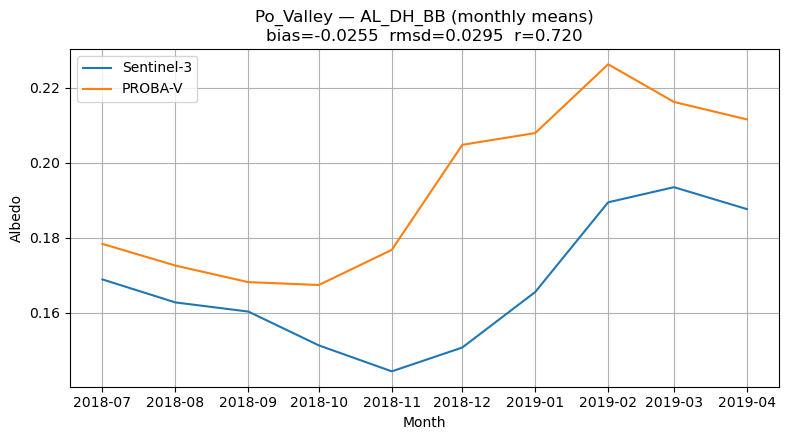

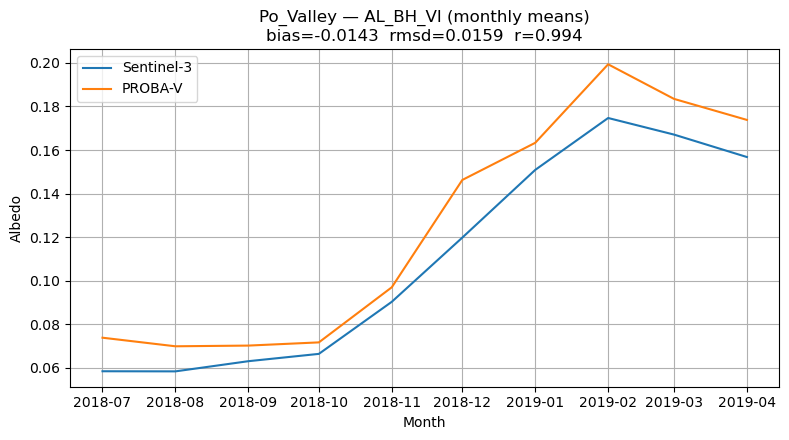

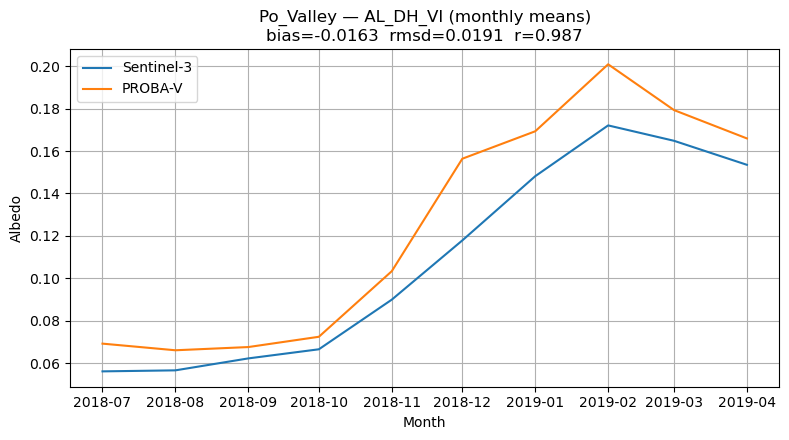

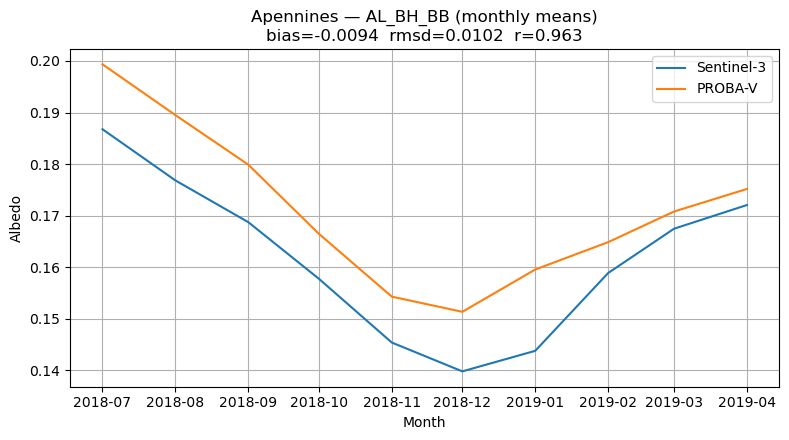

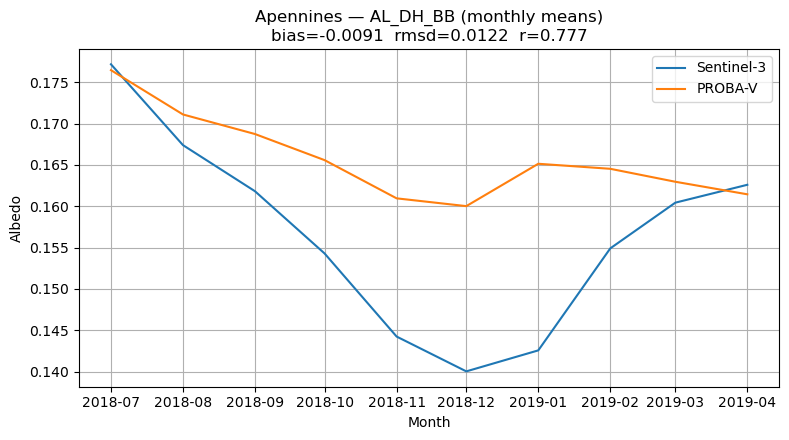

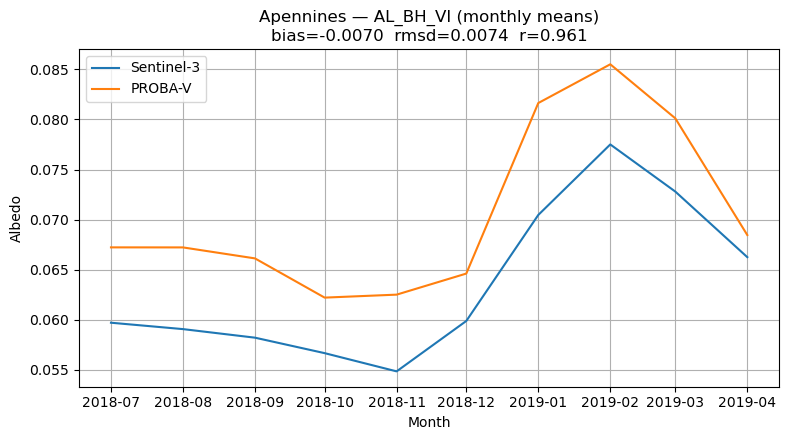

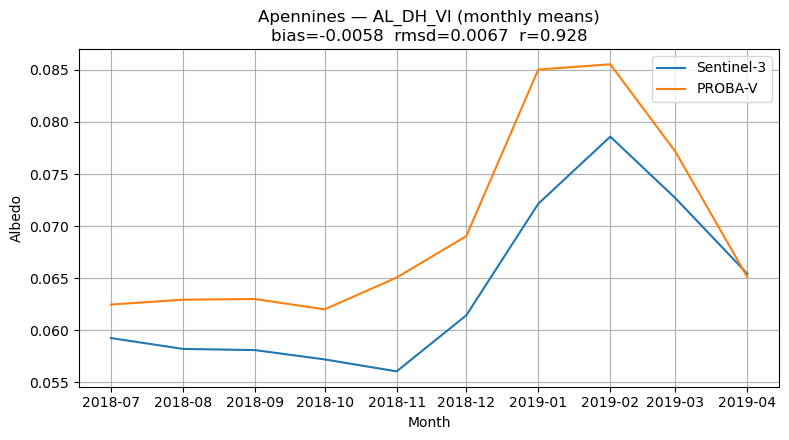

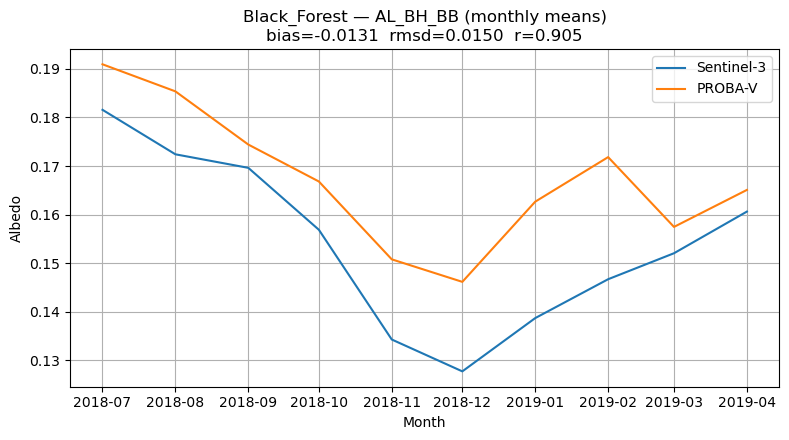

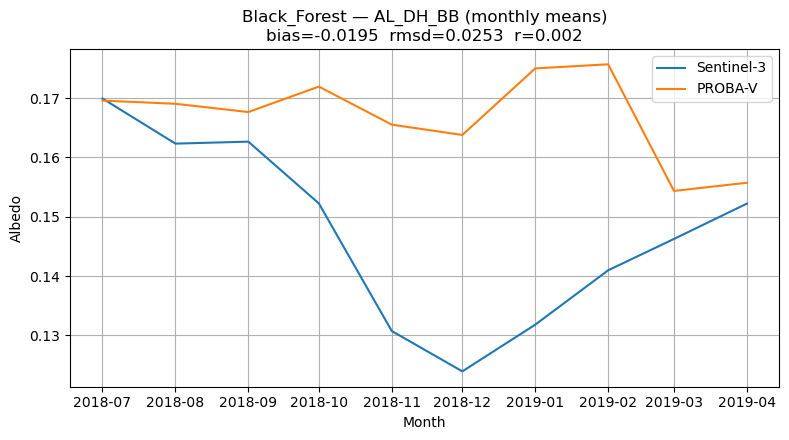

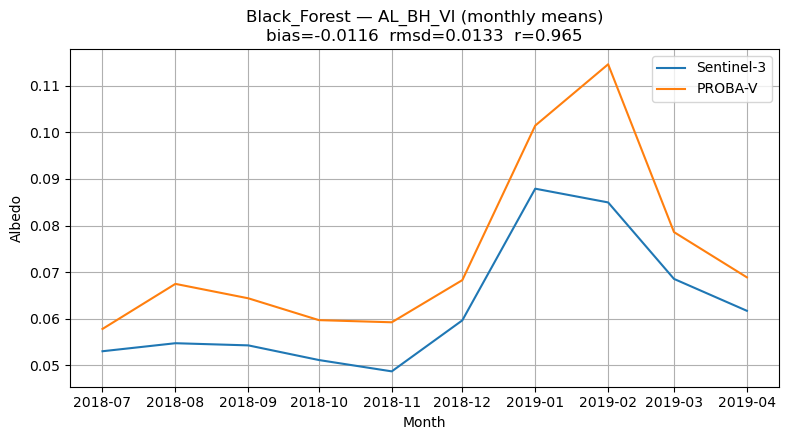

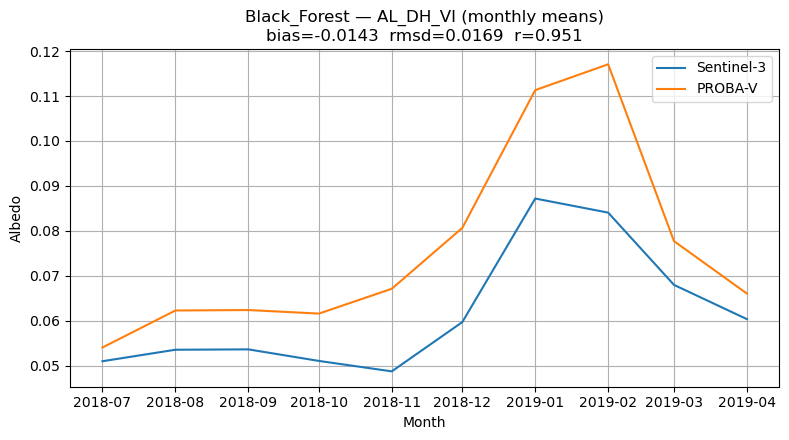

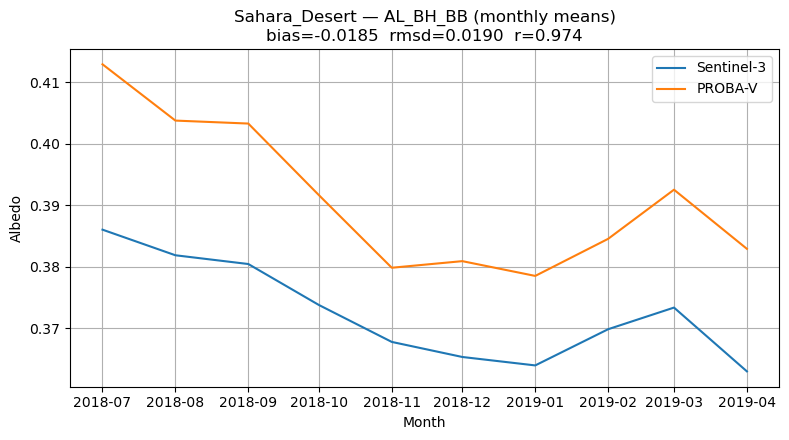

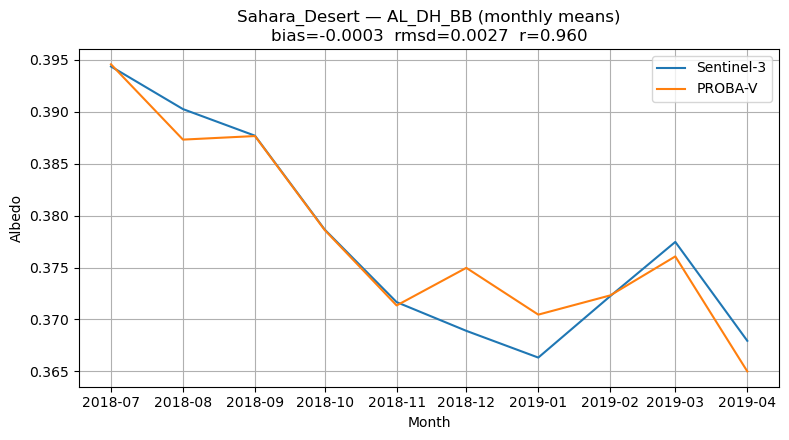

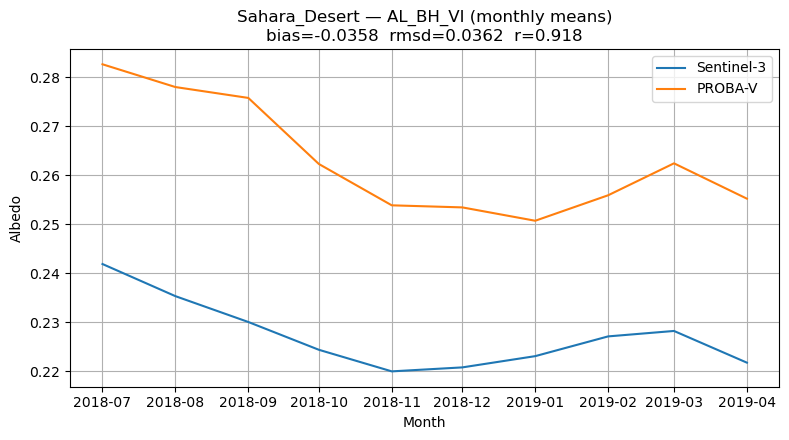

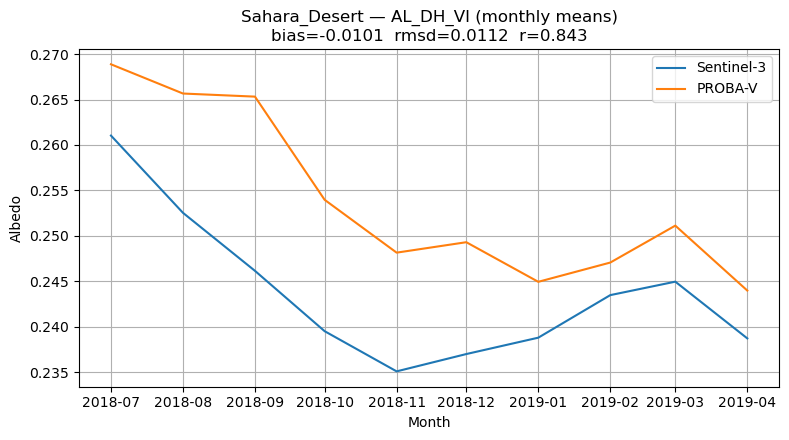

In [ ]:

def align_two_series(a: pd.Series, b: pd.Series) -> pd.DataFrame:
    idx = a.index.intersection(b.index)
    return pd.DataFrame({"S3": a.reindex(idx), "PV": b.reindex(idx)}).dropna()

def plot_region_timeseries(region_name: str, bounds, save=False, outdir="figs"):
    """Plot monthly series of area-weighted regional means for all variables."""
    s3_sub = _subset_region(ds_s3_rg, bounds)
    pv_sub = _subset_region(ds_pv,    bounds)
    if s3_sub is None or pv_sub is None:
        print(f"{region_name}: skipped (outside dataset coverage).")
        return

    for v in vars_use:
        # monthly area-weighted regional means
        s3_m = _monthly_series_weighted(s3_sub[v])
        pv_m = _monthly_series_weighted(pv_sub[v])
        df = align_two_series(s3_m, pv_m)
        if df.empty:
            print(f"{region_name} — {v}: no valid months (possibly water-only or masked).")
            continue

        # metrics for title
        diff = df["S3"] - df["PV"]
        bias = float(diff.mean())
        rmsd = float(np.sqrt((diff**2).mean()))
        corr = float(df["S3"].corr(df["PV"]))

        plt.figure(figsize=(8, 4.5))
        plt.plot(df.index, df["S3"], label="Sentinel-3")
        plt.plot(df.index, df["PV"], label="PROBA-V")
        plt.title(f"{region_name} — {v} (monthly means)\n"
                  f"bias={bias:.4f}  rmsd={rmsd:.4f}  r={corr:.3f}")
        plt.xlabel("Month")
        plt.ylabel("Albedo")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if save:
            import os
            os.makedirs(outdir, exist_ok=True)
            plt.savefig(f"{outdir}/{region_name}_{v}_monthly_timeseries.png", dpi=150)
        plt.show()

# Run for all regions
for name, bounds in regions.items():
    plot_region_timeseries(name, bounds, save=False)

*Figure 1.* Monthly time series (S3 vs PV) for each region & variable.

####  Plot full-domain monthly time-series plots

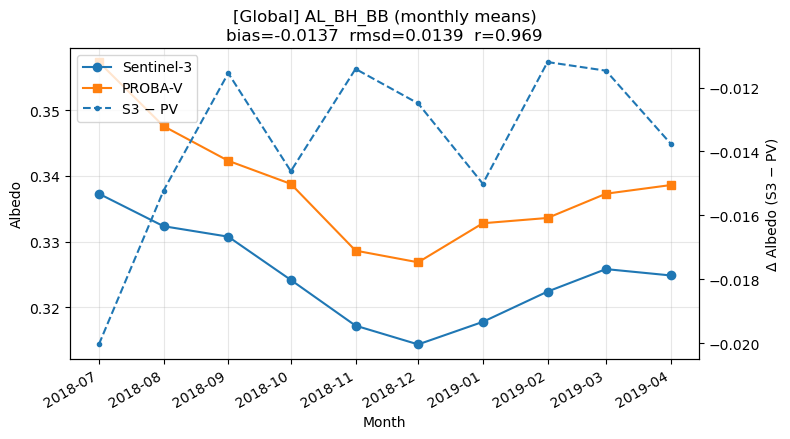

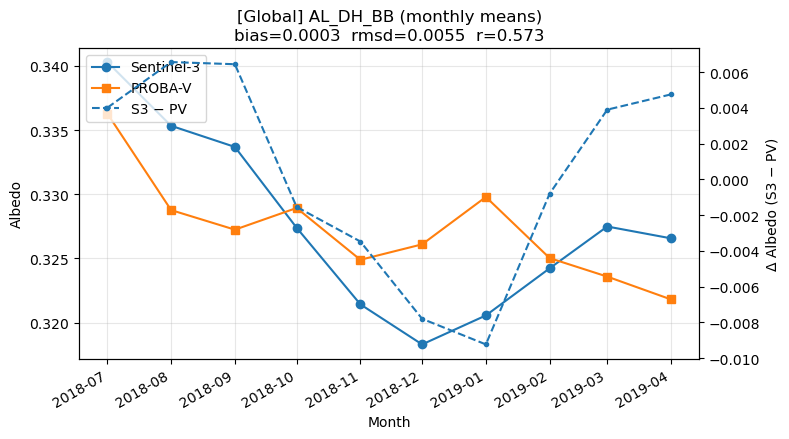

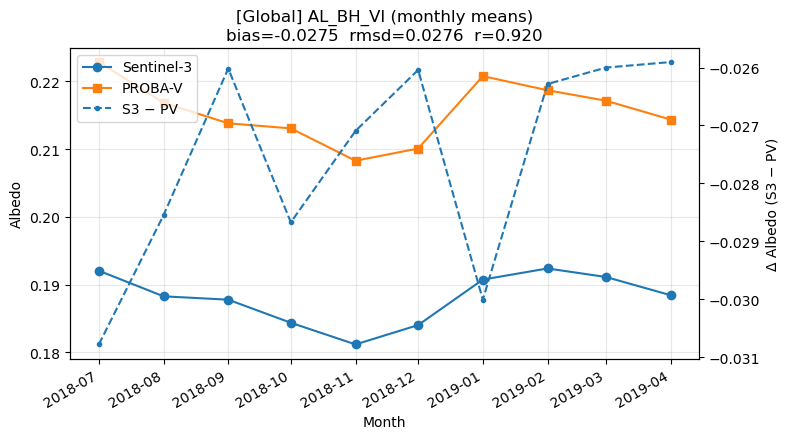

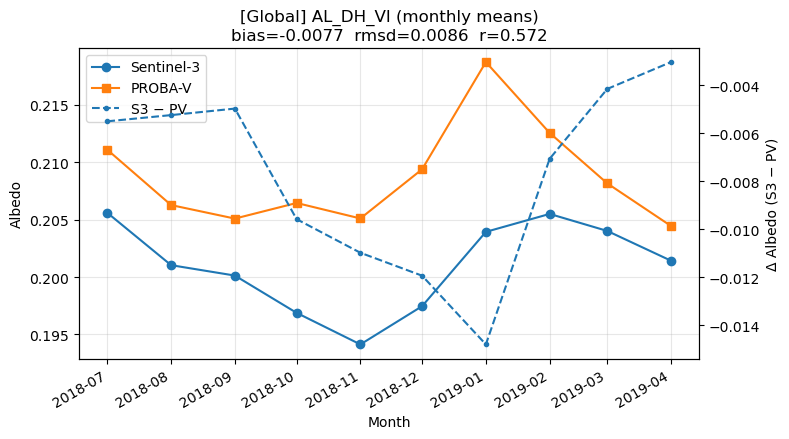

In [ ]:

def monthly_weighted_series(da: xr.DataArray) -> pd.Series:
    """Area-weighted (cosφ) spatial mean per time → monthly mean Series."""
    w = np.cos(np.deg2rad(da.latitude))
    w = w / w.mean()
    num = (da * w).sum(dim=("latitude","longitude"), skipna=True)
    den = (xr.where(np.isfinite(da), 1.0, 0.0) * w).sum(dim=("latitude","longitude"))
    ts = (num / den).to_series()
    m = ts.groupby(ts.index.to_period("M")).mean()
    return m.to_timestamp(how="start")

def plot_global_timeseries(save=False, outdir="figs", ylims=None, show_diff=True):
    for v in vars_use:
        s3_m = monthly_weighted_series(ds_s3_rg[v])
        pv_m = monthly_weighted_series(ds_pv[v])
        idx  = s3_m.index.intersection(pv_m.index)
        df   = pd.DataFrame({"S3": s3_m.reindex(idx), "PV": pv_m.reindex(idx)}).dropna()
        if df.empty:
            print(f"[Global] {v}: no overlapping months.")
            continue

        diff = df["S3"] - df["PV"]
        bias = float(diff.mean())
        rmsd = float(np.sqrt((diff**2).mean()))
        corr = float(df["S3"].corr(df["PV"]))

        fig, ax = plt.subplots(figsize=(8, 4.5))
        ax.plot(df.index, df["S3"], marker="o", label="Sentinel-3")
        ax.plot(df.index, df["PV"], marker="s", label="PROBA-V")
        ax.set_title(f"[Global] {v} (monthly means)\n"
                     f"bias={bias:.4f}  rmsd={rmsd:.4f}  r={corr:.3f}")
        ax.set_xlabel("Month")
        ax.set_ylabel("Albedo")
        if ylims: ax.set_ylim(*ylims)
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        fig.autofmt_xdate()

        if show_diff:
            ax2 = ax.twinx()
            ax2.plot(df.index, diff, linestyle="--", marker=".", label="S3 − PV")
            ax2.set_ylabel("Δ Albedo (S3 − PV)")
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
        else:
            ax.legend(loc="upper left")

        plt.tight_layout()
        if save:
            import os
            os.makedirs(outdir, exist_ok=True)
            fig.savefig(f"{outdir}/Full-domain_{v}_monthly_timeseries.png", dpi=150)
        plt.show()

# Call it
plot_global_timeseries(save=False)

*Figure 2.* Full-domain monthly time-series plots.

(section-4)=
### Take-Home Messages
- Sentinel-3 and PROBA-V show consistent surface albedo patterns globally.

- The bias highlights systematic differences, possibly due to calibration and angular effects.

- The RMSD quantifies the magnitude of deviations.

- The correlation confirms the ability of both sensors to track temporal variability.

## ℹ️ If you want to know more
### Key Resources

* [Surface albedo 10-daily gridded data from 1981 to present](https://cds.climate.copernicus.eu/datasets?q=albedo&limit=30)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References


**[[1]](https://doi.org/10.1175/1520-0450(1999)038<0712:ROLSAF>2.0.CO;2)** Lucht, W., et al. (2000). *Retrieval of land surface albedo from satellite observations: A simulation study.* Remote Sensing of Environment, 64(3), 214–231.

**[[2]](https://doi.org/10.1016/S0034-4257(02)00091-3)** Schaaf, C. B., et al. (2002). *First operational BRDF, albedo and nadir reflectance products from MODIS.* Remote Sensing of Environment, 83(1–2), 135–148.

**[[3]](https://www.tandfonline.com/doi/full/10.1080/01431161.2014.883097)** Dierckx, W., et al. (2014). *PROBA-V mission for global vegetation monitoring: Standard products and image quality.* International Journal of Remote Sensing, 35(7), 2589–2614.

**[[4]](https://doi.org/10.1016/j.rse.2018.06.038)** Carrer, D., et al. (2018). *Evaluation of satellite albedo products over land.* Remote Sensing of Environment, 216, 453–470.

**[[5]](https://doi.org/10.1016/j.isprsjprs.2020.03.021)** Liang, S., et al. (2020). *Remote sensing of land surface albedo: Progress and perspectives.* ISPRS Journal of Photogrammetry and Remote Sensing, 163, 101–122.

**[[6]](https://cds.climate.copernicus.eu/datasets/satellite-albedo?tab=overview)** Copernicus Climate Change Service (C3S). (2020). *Surface albedo from satellite observations.* Climate Data Store.

**[[7]](https://doi.org/10.1029/2006GL025734)** Giorgi, F. (2006). *Climate change hot-spots.* Geophysical Research Letters, 33(8).

**[[8]](https://doi.org/10.1007/s00382-020-05261-y)** Cherif, C., et al. (2020). *Climate change in the Mediterranean: Analysis and projections.* Climate Dynamics, 54, 3711–3730.
